In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rfpimp
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.model_selection import train_test_split, StratifiedKFold

sys.path.append('../')
from utils.utils import plot_feature_imp
from utils.feature_imp import (oob_accuracy,
                               permutation_importances,
                               drop_column_importances)

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('../data/rent.txt')
df.head()

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1
2,1.0,1,2850,-74.0018,40.7388,3
3,1.0,1,3275,-73.9677,40.7539,1
4,1.0,4,3350,-73.9493,40.8241,1


In [4]:
# Convert to numpy
X_train = df.drop(['interest_level'], axis=1).values
y_train = df['interest_level'].values
y_train = pd.Series(y_train).map({1: 0, 2: 1, 3: 2}).values
features = df.columns[:-1]
print(f'Shape : {X_train.shape}, {y_train.shape}')

Shape : (49352, 5), (49352,)


In [5]:
# Create CV object
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Sklearn feature importance

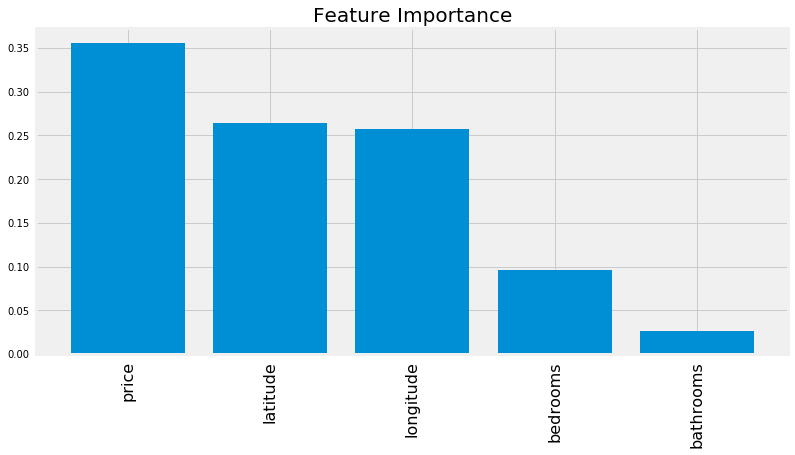

In [6]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                oob_score=True,
                                n_jobs=-1)
rf_clf.fit(X_train, y_train)
plot_feature_imp(rf_clf, feature_names=features)

# Permutation feature importance

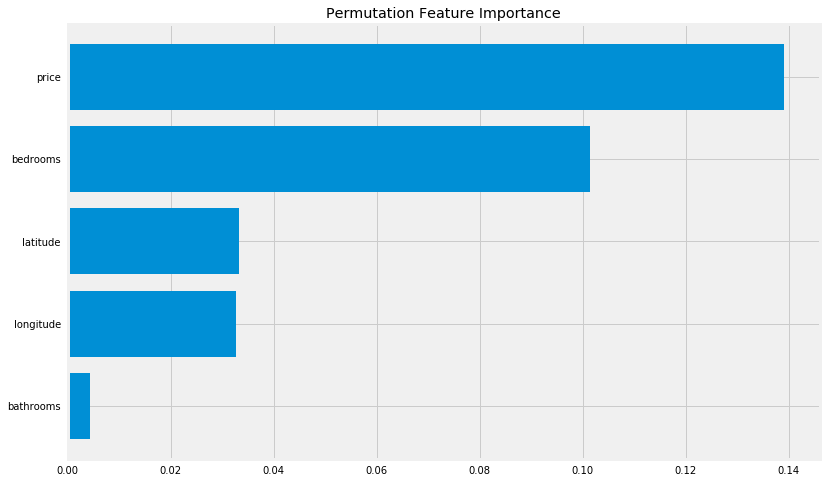

In [7]:
perm_imp = permutation_importances(rf_clf, X_train, y_train, oob_accuracy)
idxs = np.argsort(perm_imp)
plt.figure(figsize=(12, 8))
plt.barh(range(5), perm_imp[idxs])
plt.yticks(range(5), features[idxs])
plt.title("Permutation Feature Importance");

# Drop Column Feature Importance

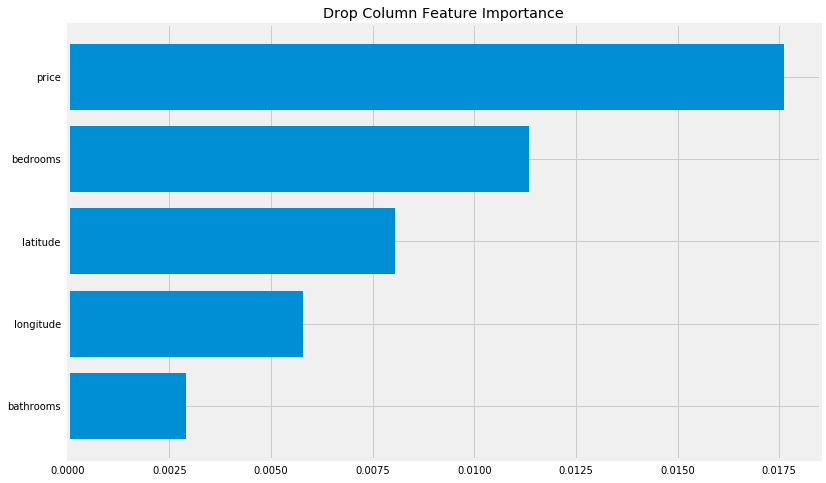

In [8]:
# Fit rf classifier using new df with random column
rf_clf = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                oob_score=True,
                                n_jobs=-1)
drop_col_imp = drop_column_importances(rf_clf, X_train, y_train)

idxs = np.argsort(drop_col_imp)
plt.figure(figsize=(12, 8))
plt.barh(range(5), drop_col_imp[idxs])
plt.yticks(range(5), features[idxs])
plt.title("Drop Column Feature Importance");

# Add Feature Randomly Distributed

In [9]:
# Add random column to X_train
random = np.random.random(len(y_train)).reshape(-1, 1)
X_train = np.concatenate([X_train, random], axis=1)
features = list(features) + ['random']

In [10]:
# Fit rf classifier using new df with random column
rf_clf = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                oob_score=True,
                                n_jobs=-1)
rf_clf.fit(X_train, y_train)
perm_imp = permutation_importances(rf_clf, X_train, y_train, oob_accuracy)

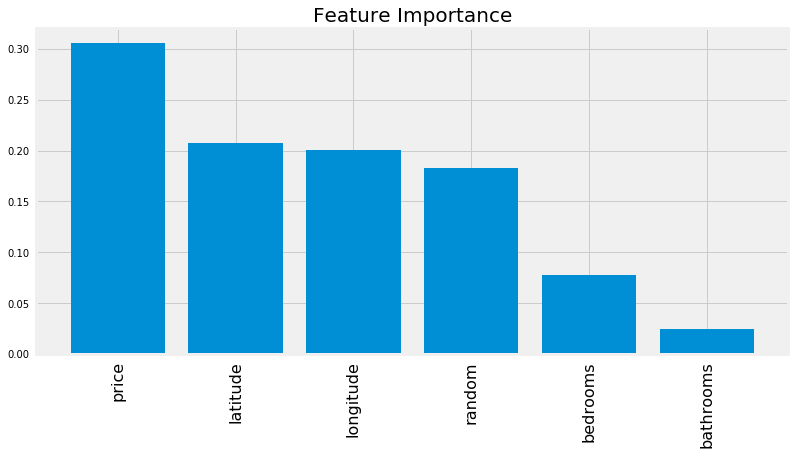

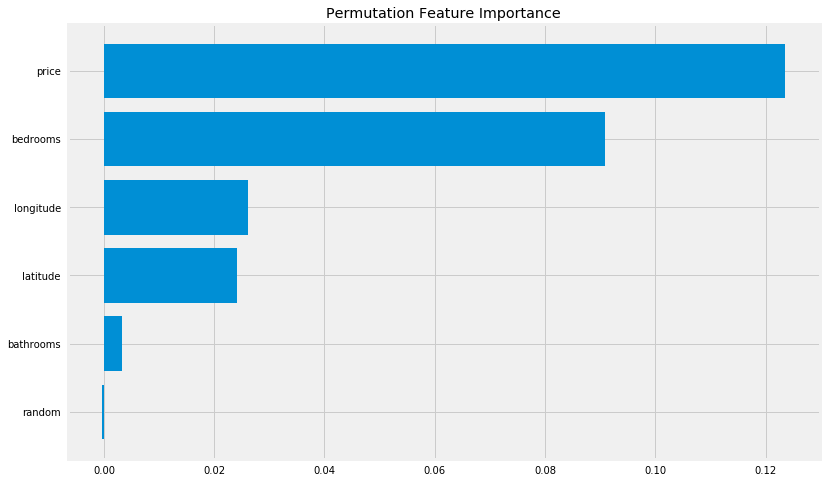

In [11]:
plot_feature_imp(rf_clf, feature_names=features)
idxs = np.argsort(perm_imp)
plt.figure(figsize=(12, 8))
plt.barh(range(6), perm_imp[idxs])
plt.yticks(range(6), np.array(features)[idxs])
plt.title("Permutation Feature Importance");

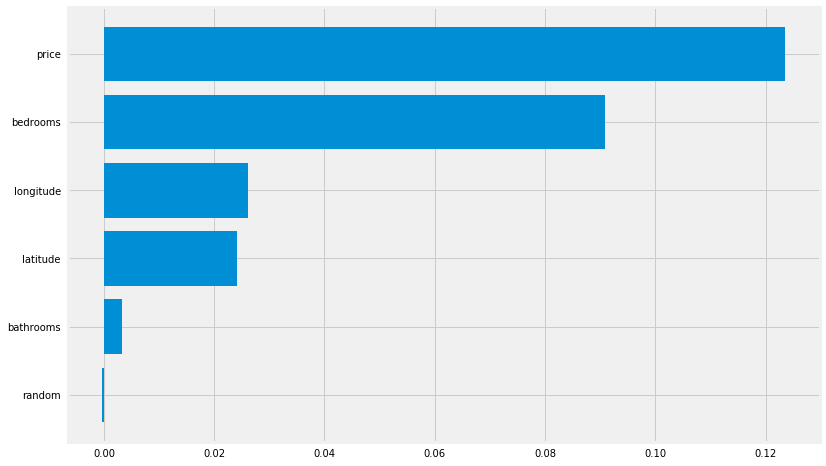

In [12]:
# Fit rf classifier using new df with random column
rf_clf = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                oob_score=True,
                                n_jobs=-1)
drop_col_imp = drop_column_importances(rf_clf, X_train, y_train)

idxs = np.argsort(perm_imp)
plt.figure(figsize=(12, 8))
plt.barh(range(6), perm_imp[idxs])
plt.yticks(range(6), np.array(features)[idxs]);

# Add Duplicate Feature

In [13]:
# Add a duplicate for longtitude
X_train = np.insert(X_train, 6, X_train[:, 3], axis=1)
features.append('longitude_dup')

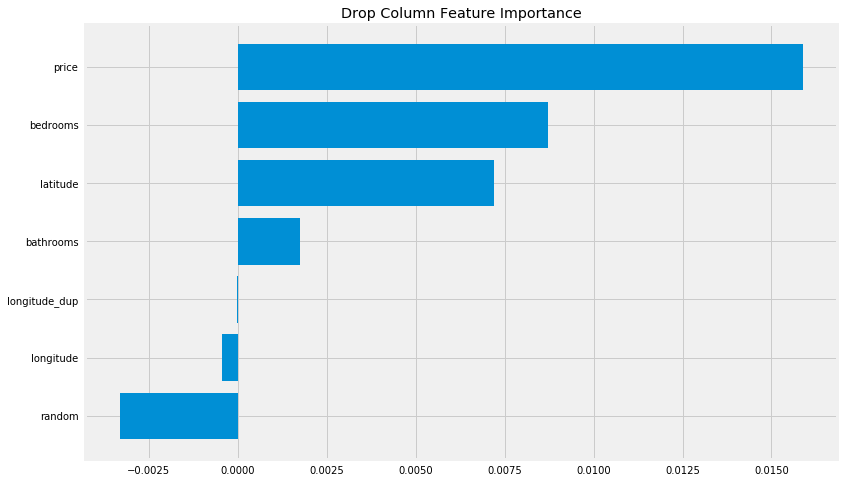

In [14]:
# Fit rf classifier using new df with random column using drop column method
rf_clf = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                oob_score=True,
                                n_jobs=-1)
perm_imp = drop_column_importances(rf_clf, X_train, y_train)
idxs = np.argsort(perm_imp)
plt.figure(figsize=(12, 8))
plt.barh(range(7), perm_imp[idxs])
plt.yticks(range(7), np.array(features)[idxs])
plt.title("Drop Column Feature Importance");

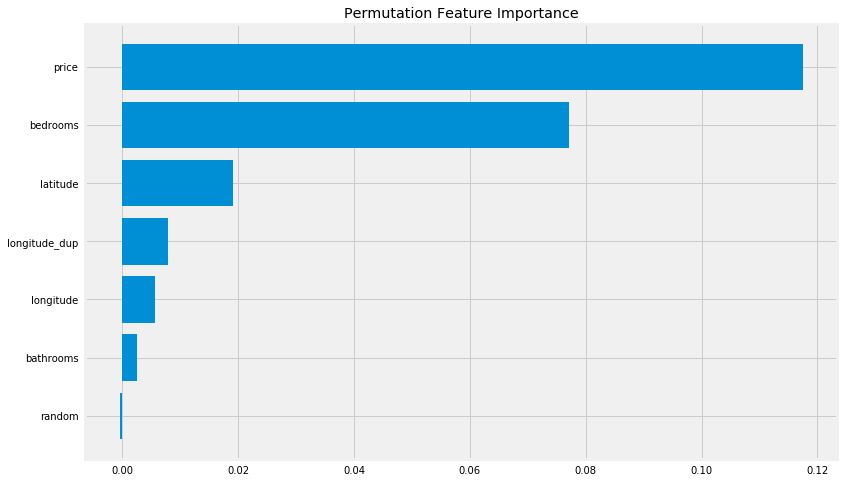

In [15]:
# Fit rf classifier using new df with random column using permutation method
rf_clf = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                oob_score=True,
                                n_jobs=-1)
rf_clf.fit(X_train, y_train)
perm_imp = permutation_importances(
    rf_clf, X_train, y_train, oob_accuracy)

idxs = np.argsort(perm_imp)
plt.figure(figsize=(12, 8))
plt.barh(range(7), perm_imp[idxs])
plt.yticks(range(7), np.array(features)[idxs])
plt.title("Permutation Feature Importance");